# Compact Convolutional Transformers

This week we try to train Vision Transformer-like network for cifar10 images classification.

This task is based on paper [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/pdf/2104.05704.pdf)

## CIFAR dataset

You have already met this dataset in seminar 2.

* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
# when running in colab, un-comment this
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

In [7]:
#!L
import numpy as np
import random
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


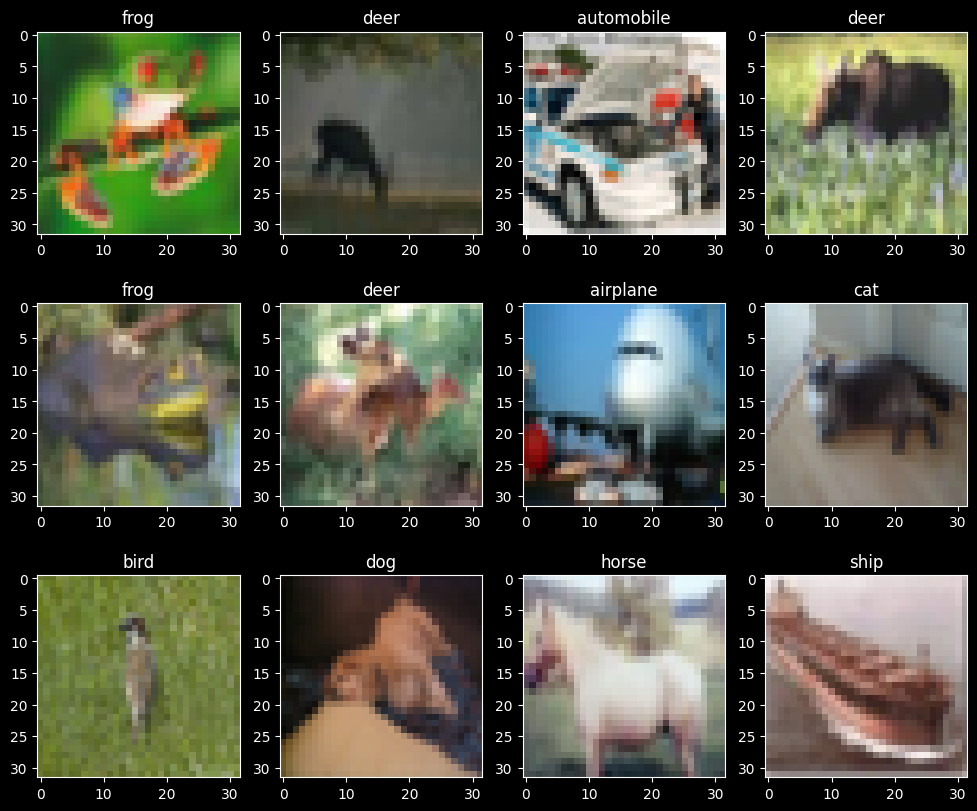

In [8]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.transpose(X_train[i],[1,2,0]))
    plt.title(class_names[y_train[i]])

## Prepare dataset and loss

The following code is based on homework 1-pt2 and should be familiar to you.

In [9]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import tqdm

In [10]:
#!L
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [11]:
#!L
def compute_loss(logits, y_batch):
    return F.cross_entropy(logits, y_batch).mean().cpu()

In [12]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2470, 0.2435, 0.2616))

transform_augment = transforms.Compose([
    transforms.RandomResizedCrop((32,32), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation([-5, 5]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [13]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=50,
                                              shuffle=True,
                                              num_workers=12)
val_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                              batch_size=50,
                                              shuffle=False,
                                              num_workers=12)


## Task 1. Multi-head attention

Your turn!

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:50%">

Let's implement MultiHeadAttention for beggining. It's already implemented in pytorch, so we will use `nn.MultiHeadAttention` for testing of your implementation.

As a reminder, (one-head) attention implements a simple formula: $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$, where $d_k$ is size of K


In [14]:
class CustomMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.in_proj = nn.Linear(embed_dim, 3 * embed_dim)  # don't change the name
        self.out_proj = nn.Linear(embed_dim, embed_dim)  # don't change the name
        
        self.norm_coeff = self.head_dim ** 0.5
        
        self.attention_dropout = nn.Dropout(dropout)
        
    def forward(self, qkv):
        """
        qkv - query, key and value - it should be the same tensor since we implement self-attention
        """

        qkv = self.in_proj(qkv)
        q, k, v = torch.split(qkv, self.embed_dim, -1)

        #todo
        attention_heads = []
        for i in range(self.num_heads):
            scaled_product = torch.matmul(q[..., i * self.head_dim:(i + 1) * self.head_dim], 
                                          k[..., i * self.head_dim:(i + 1) * self.head_dim].transpose(-1, -2)) / self.norm_coeff
            scaled_product = self.attention_dropout(scaled_product)
            scaled_product = torch.softmax(scaled_product, dim=-1)
            attention_head = torch.matmul(scaled_product,
                                          v[..., i * self.head_dim:(i + 1) * self.head_dim]) 
            attention_heads.append(attention_head)                 
                                             
        attention_heads = torch.cat(attention_heads, dim=-1)
        mha_out = self.out_proj(attention_heads)
        
        # YOUR CODE
        # 1. apply self.in_proj to qkv
        # 2. split the result of step 1 on three equal parts of size self.embed_dim: query, key, value
        # 3. compute scaled dot-product attention for different heads in loop. 
        #    i-th head will work on query[:, :, i*head_dim: (i+1)*head_dim], 
        #    key[:, :, i*head_dim: (i+1)*head_dim], value[:, :, i*head_dim: (i+1)*head_dim]
        # 4. apply dropout for each head result
        # 5. concat all results
        # 6. apply self.out_proj to the result of step 5

        return mha_out

Let's check that your implementation works like `torch.nn.MultiheadAttention`

In [15]:
mha = torch.nn.MultiheadAttention(embed_dim=128, num_heads=16, batch_first=True)

In [16]:
custom_mha = CustomMultiHeadSelfAttention(embed_dim=128, num_heads=16)
custom_mha.in_proj.weight = mha.in_proj_weight
custom_mha.in_proj.bias = mha.in_proj_bias
custom_mha.out_proj.weight = mha.out_proj.weight
custom_mha.out_proj.bias = mha.out_proj.bias

In [17]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

for _ in range(100):
    a = torch.rand((1, 10, 128))
    out1 = mha(a, a, a)[0].cpu().detach().numpy()
    out2 = custom_mha(a).cpu().detach().numpy()
    # print(f'Torch impl shape:', out1.shape)
    # print(f'Custom impl shape:', out2.shape)
    assert np.allclose(out1, out2, atol=1e-6), f"{out1} {out2}"
    
print ("Congratulations! It works!")

Congratulations! It works!


## Task 2: Step-wise learning rate with warm-up

Your task is to implement class that works as `torch.optim.lr_scheduler.StepLR` but supports warm-up.

First of all, examine the docstring and implementation of `StepLR` scheduler:

In [57]:
# torch.optim.lr_scheduler.StepLR()

Then implement `get_lr()` method. It should work as following:
1. If `self.last_epoch` is in `[0, self.warmup_epochs)`, then scheduler is in warm-up mode and learning rate should lineary increase during epochs from `self.warmup_lr_init` to `self.base_lrs` (which is the original learning rate of optimizer)
2. If `self.last_epoch` is equal to `self.warmup_epochs`, then just return `self.base_lrs`.
3. If `self.last_epoch - self.warmup_epochs` is not divisible by `self.step_size` then just return the previous learning rate which is available through `[group['lr'] for group in self.optimizer.param_groups]`
4. If `self.last_epoch - self.warmup_epochs` is divisible by `self.step_size` and the current learning rate multiplied by `self.gamma` is not less then self.min_lr, then multiply it and return the new value.
5. Otherwise just return the last learning rate

In [55]:
class StepLRWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, step_size, gamma=0.1, warmup_epochs=3, warmup_lr_init=1e-5, 
                 min_lr=1e-5,
                 last_epoch=-1, verbose=False):
        self.step_size = step_size
        self.gamma = gamma
        self.warmup_epochs = warmup_epochs
        self.warmup_lr_init = warmup_lr_init
        self.min_lr = min_lr
        
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if (self.last_epoch == 0):
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        # YOUR CODE
        elif self.last_epoch in list(range(0, self.warmup_epochs)):
            base_lr = [group['initial_lr'] for group in self.optimizer.param_groups][0]
            warmup_lr = self.warmup_lr_init + (base_lr - self.warmup_lr_init) / self.warmup_epochs * self.last_epoch
            return [warmup_lr]
        elif self.last_epoch == self.warmup_epochs:
            return [group['initial_lr'] for group in self.optimizer.param_groups]
        elif (self.last_epoch - self.warmup_epochs) % self.step_size != 0:
            return [group['lr'] for group in self.optimizer.param_groups]
        elif (self.last_epoch - self.warmup_epochs) % self.step_size == 0:
            lr = [group['lr'] * self.gamma for group in self.optimizer.param_groups][0]
            lr = max(lr, self.min_lr)
            return [lr]
        else:
            return [group['lr'] for group in self.optimizer.param_groups]
        

Let's check what you have written.


All asserts were passed!


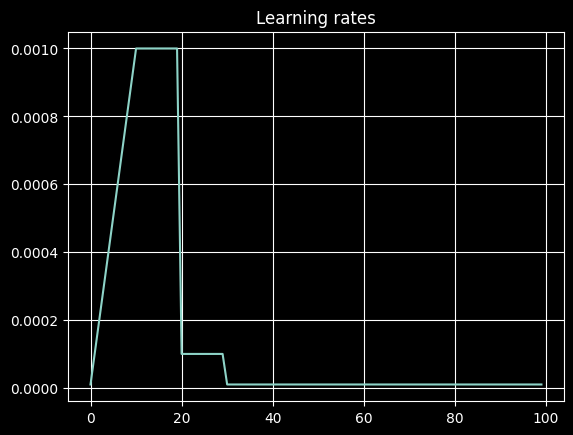

In [56]:
WARMUP_LR_INIT = 1e-5
WARMUP_EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
MIN_LR = 1e-5
OPT_LR = 1e-3

dummy_net = nn.Sequential(nn.Linear(10,10))
dummy_opt = torch.optim.Adam(dummy_net.parameters(), lr=OPT_LR)

scheduler = StepLRWithWarmup(dummy_opt, step_size=STEP_SIZE, gamma=GAMMA, 
                                      warmup_epochs=WARMUP_EPOCHS, warmup_lr_init=WARMUP_LR_INIT,
                                      min_lr=MIN_LR)

# we need to do at least one optimizer step before calling scheduler.step()
# in order to make pytorch happy
dummy_opt.step()  


learning_rates = []
for i in range(100):
    learning_rates.append(scheduler.get_last_lr())
    scheduler.step()
    
plt.plot(learning_rates)
plt.grid()
plt.title('Learning rates')
    
assert np.isclose(learning_rates[0], WARMUP_LR_INIT), \
    f"LR on the first epoch should be equal to {WARMUP_LR_INIT}, actual value {learning_rates[0]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS], OPT_LR), \
    f"LR after warmup shold be equal to {OPT_LR}, actual value {learning_rates[WARMUP_EPOCHS]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE-1], OPT_LR), \
    f"LR after warmup + (STEP_SIZE-1) steps should be equal to {OPT_LR}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE], OPT_LR*GAMMA), \
    f"LR after warmup + (STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1], OPT_LR*GAMMA), \
    f"LR after warmup + (2*STEP_SIZE-1) steps should be equal to {OPT_LR*GAMMA}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+2*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (2*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+2*STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+3*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (3*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+3*STEP_SIZE]}"

for i in range(WARMUP_EPOCHS):
    expected_val = WARMUP_LR_INIT + i*(OPT_LR-WARMUP_LR_INIT) / WARMUP_EPOCHS
    actual_val = learning_rates[i]
    assert np.isclose(actual_val, expected_val), \
        f"LR should linary increase from {WARMUP_LR_INIT} to {OPT_LR} during warmup."\
        f"Expected: {expected_val}, actual: {actual_val}, iteration={i}"
assert all(elem[0] >= MIN_LR for elem in learning_rates)
print("All asserts were passed!")

## Task 3. Compact Convolutional Transformer

During seminar you learned the main components of vision transformer: Tokenizer, Transformer encoder, position embeddings. At this point, it's expected that you have solved the ipython notebook from the seminar. If you didn't, then you know what to do before starting the current task)

Your task is to implement Compact Convolutional Transformer (CCT). It has two main changes comparing to the original ViT that was implemented during seminar. The first one is in tokenizer. Authors of CCT suggested to apply the first convolution with stride=1 allowing transformer to work with input patches that overlaps with each other. Since simple removing of stride increases the spatial resolution of the input tensor, we use MaxPool2d with desired stride in order to reduce the number of tokens.

In [ ]:
class TokenizerCCT(nn.Module):
    def __init__(self,
                 kernel_size=3, stride=1, padding=1,
                 pooling_kernel_size=3, pooling_stride=2, pooling_padding=1,
                 n_input_channels=3,
                 n_output_channels=64,
                 ):
        super().__init__()
        self.tokenizer_layers = nn.Sequential(
                # YOUR CODE
                # it should implement the following sequence of layers:
                # Conv2d(n_input_channels, n_output_channels, kernel_size, stride, padding, bias=False) + 
                #   + ReLU + 
                #   + MaxPool(pooling_kernel_size, pooling_stride, pooling_padding)
                nn.Conv2d(...),
                nn.ReLU(),
                nn.MaxPool2d(...))

        self.flattener = nn.Flatten(2, 3)  # flat h,w dims into token dim

    def forward(self, x):
        y = self.tokenizer_layers(x)
        y = self.flattener(y)
        y = y.transpose(-2, -1)  # swap token dim and embedding dim
        return y

The second change is that CCT uses learnable pooling instead of class token for global features extraction. Its formula is similar to attention formula:
$$y = \text{softmax}(WX^T+b) * X$$
where $X$ - layer input - matrix of shape [batch_size, n_tokens, n_embedding], $W$, $b$ - learnable parameters, that transform each token embedding vector to 1 element (in fact it's just a linear layer with output_dim=1).

In [ ]:
class SeqPooling(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.attention_pool = nn.Linear(embedding_dim, 1)
          
    def forward(self, x):
        # YOUR CODE
        # 1. apply self.attention_pool to x
        w = ...
        # 2. take softmax over the first dim (token dim)
        w = F.softmax(w, dim=1)
        # 3. transpose two last dims of w to make its shape be equal to [N, 1, n_tokens]
        w = ...
        
        # 4. call torch.matmul from 'w' and input tensor 'x'
        y = ...
        
        # 5. now 'y' shape is [N, 1, embedding_dim]. Squeeze the second dim
        y = ...
        
        return y

The following three modules were implemented by you during seminar, so you can just copy-paste their implementations.

In [ ]:
def create_mlp(embedding_dim, mlp_size, dropout_rate):
    return nn.Sequential(
        # YOUR CODE: Linear + GELU + Dropout + Linear + Dropout
        nn.Linear(..
    )

In [ ]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        # YOUR CODE: generate random tensor, binarize it, cast to x.dtype, multiply x by the mask, 
        # devide the result on keep_prob
        random_tensor = torch.rand(...)
        output = ...
        return output

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_size, dropout=0.1, attention_dropout=0.1,
                 drop_path_rate=0.1):
        super().__init__()
        # YOUR CODE
        self.attention_pre_norm = ...
        self.attention = torch.nn.MultiheadAttention(...)
        self.attention_output_dropout = nn.Dropout(dropout)

        self.mlp_pre_norm = ...
        self.mlp = create_mlp(...)
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else nn.Identity()

    def forward(self, x):
        # first block
        y = self.attention_pre_norm(x)
        attention = self.attention(y, y, y)[0]
        attention = self.attention_output_dropout(attention)
        x = x + self.drop_path(attention)   # Residual connection
            
        # second block
        y = self.mlp_pre_norm(x)
        y = self.mlp(y)
        x = x + self.drop_path(y)  # Residual connection
        return x

The final class for the CCT. It looks the same as `VisionTransformer` class in seminar notebook, except the custom tokenizer and pooling. Here we implement a simple version of CCT, whose Tokenizer consist of one convolution of 3x3.

In [ ]:
class CompactConvTransformer3x1(nn.Module):
    def __init__(self,
                 input_height, input_width,
                 n_tokens,
                 n_input_channels,
                 embedding_dim,
                 num_layers,
                 num_heads=4,
                 num_classes=10,
                 mlp_ratio=2,
                 dropout=0.1,
                 attention_dropout=0.1,
                 stochastic_depth=0.1):
        super().__init__()
        
        # 1. Tokenizer
        pooling_stride = 2
        self.tokenizer = TokenizerCCT(kernel_size=3, stride=1, padding=1, 
                                      pooling_kernel_size=3, pooling_stride=pooling_stride, pooling_padding=1,
                                      n_output_channels=embedding_dim)
        n_tokens = input_height // pooling_stride
        
        # 2. Positional embeddings
        self.positional_embeddings = torch.nn.Parameter(
            torch.empty((1, n_tokens*n_tokens, embedding_dim)), requires_grad=True)
        torch.nn.init.trunc_normal_(self.positional_embeddings, std=0.2)
        
        # 3. TransformerEncoder with DropPath
        mlp_size = int(embedding_dim * mlp_ratio)
        layers_drop_path_rate = [x.item() for x in torch.linspace(0, stochastic_depth, num_layers)]
        self.blocks = nn.Sequential(*[
            TransformerEncoder(
                embedding_dim, num_heads, mlp_size, 
                dropout=dropout, attention_dropout=attention_dropout,
                drop_path_rate=layers_drop_path_rate[i]) 
            for i in range(num_layers)])
        
        # 4. normalization before pooling
        self.norm = nn.LayerNorm(embedding_dim)
        
        # 5. sequence pooling
        self.pool = SeqPooling(embedding_dim)

        # 6. layer for the final prediction
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        # YOUR CODE
        # 1. apply tokenizer to x
        patch_embeddings = ...
        
        # 2. add position embeddings
        x = patch_embeddings + self.positional_embeddings

        # 3. apply transformer encoder blocks
        for block in self.blocks:
            x = ...
            
        # 4. apply self.norm
        x = ...
        
        # 5. apply sequence pooling
        x = ...
        
        # 6. final prediction
        x = self.fc(x)
        return x

## Final training 

If everything was implemented correctly, the following code will give you a model with > 85.5% accuracy (in fact it should be ~87.5%). If you see a smaller number, check your implementation of modules above.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

model = CompactConvTransformer3x1(input_height=32, input_width=32, n_tokens=16, n_input_channels=3, 
                                  embedding_dim=128, num_layers=4, num_heads=4, num_classes=10, mlp_ratio=2)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = StepLRWithWarmup(opt, 40, gamma=0.3, warmup_epochs=10)

In [ ]:
import time
num_epochs = 120 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    train_loss = []
    val_accuracy = []
    
    for X_batch, y_batch in train_batch_gen:
        opt.zero_grad()
        # train on batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = compute_loss(logits, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.numpy())
    print (scheduler.get_last_lr())
    scheduler.step()
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        X_batch = X_batch.to(device)
        y_batch = y_batch.numpy()
        logits = model(X_batch).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss)))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy) * 100))